In [1]:
import numpy as np
import pickle
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from time import time, sleep

from utils import *
from jigsaws_utils import *
from custom_pca import custom_pca
from video_loader import VideoLoader
from autoencoders import *
from physionet_pytorch.utils.get_data import *

import warnings
warnings.simplefilter('ignore', category=np.ComplexWarning)

def cross_predict(model, gram_matrix, y, nsplits=5, d_transform=None):
    nsample = len(y)
    nsample_per_group = int(nsample/nsplits)
    repeats = [nsample_per_group]*(nsplits-1)
    repeats = repeats + [nsample-np.sum(repeats)]
    groups = np.repeat(np.arange(nsplits), repeats)
    kfolder = GroupKFold(n_splits=nsplits)

    all_preds = []
    all_true = []
    for i, (train_index, test_index) in enumerate(kfolder.split(y, groups=groups)):
        if d_transform is not None:
            gram_train = d_transform(gram_matrix[train_index, :][:, train_index])
            gram_test = d_transform(gram_matrix[test_index, :][:, train_index])
        else:
            gram_train = gram_matrix[train_index, :][:, train_index]
            gram_test = gram_matrix[test_index, :][:, train_index]

        # Predict
        model.fit(gram_train, y[train_index])
        preds = model.predict(gram_test)
        all_preds.append(preds)
        all_true.append(y[test_index])

    return np.concatenate(all_preds), np.concatenate(all_true)

def evaluate_model(model, gram_matrix, y, gestures, nsplits=5, d_transform=None):
    nsample = len(y)
    nsample_per_group = int(nsample/nsplits)
    repeats = [nsample_per_group]*(nsplits-1)
    repeats = repeats + [nsample-np.sum(repeats)]
    groups = np.repeat(np.arange(nsplits), repeats)
    kfolder = GroupKFold(n_splits=nsplits)

    ngestures = len(gestures)
    confusion_matrix_cum = np.zeros((ngestures, ngestures))
    count_gesture_presence = np.zeros((ngestures, ngestures))
    accuracy_cum = 0
    for train_index, test_index in kfolder.split(y, groups=groups):
        if d_transform is not None:
            gram_train = d_transform(gram_matrix[train_index, :][:, train_index])
            gram_test = d_transform(gram_matrix[test_index, :][:, train_index])
        else:
            gram_train = gram_matrix[train_index, :][:, train_index]
            gram_test = gram_matrix[test_index, :][:, train_index]

        # Predict
        model.fit(gram_train, y[train_index])
        preds = model.predict(gram_test)
        accuracy_cum += np.mean(y[test_index]==preds)
        cm = confusion_matrix(y[test_index], preds, normalize='true')

        # Handle of missing gestures
        current_gesture_presence = np.ones(cm.shape)
        if cm.shape != (ngestures,ngestures):
            missing_gestures = np.setdiff1d(np.setdiff1d(gestures, preds), y[test_index])

            print(gestures, missing_gestures)
            for g in missing_gestures:
                gi = g2i[g]
                cm = np.insert(cm, gi, 0, axis=0)
                cm = np.insert(cm, gi, 0, axis=1)
                #cm[gi,gi] = 1
                print('AAA')
                print(current_gesture_presence)
                current_gesture_presence = np.insert(current_gesture_presence, gi, 0, axis=0)
                print('BBB')
                print(current_gesture_presence)
                current_gesture_presence = np.insert(current_gesture_presence, gi, 0, axis=1)
                print('CCC')
        confusion_matrix_cum += cm
        count_gesture_presence += current_gesture_presence
        print(current_gesture_presence)
    #if np.any(count_gesture_presence==0):
    #    print('In evaluate_model, zero count:')
    print('End of splits')
    print(count_gesture_presence)
    average_confusion_matrix = confusion_matrix_cum/count_gesture_presence

    accuracy = accuracy_cum / float(nsplits)
    weighted_accuracy = np.mean(np.diag(average_confusion_matrix))

    return accuracy, weighted_accuracy, average_confusion_matrix

## Evaluation for 2 classes setup

In [2]:
# Load data and setup
data_2class = np.load('data/physionetmmmi/2class.npz')
X, y = np.transpose(data_2class['X'], [0,2,1]), data_2class['y']
print(X.shape, y.shape)

ks = np.arange(1, 8)
gammas = np.logspace(-10, -5, base=2, num=10)
ncomp = 10

(4410, 480, 64) (4410,)


In [3]:
filename_X_ma = 'data_generated/physionet/2class/X_matrices.pkl'
filename_gram = 'data/physionet/2class/gram_matrix.pkl'

algo_accuracies = {}

start = time()
for dist, dist_name in [(martin_dist, 'Martin'), (frob_dist, 'Frobenius')]:
    for algo, nhyper in [('KNN', len(ks)), ('SVM', len(gammas))]:
        algo_accuracies[f'{algo}-{dist_name}'] = np.zeros(nhyper)
        
    try:
        X_ma = pickle.load(open(filename_X_ma, 'rb'))
        print('Loaded X with matrices from file')
    except:
        X_ma = []
        for seq in X:
            compression_model = custom_pca(ncomp)
            compression_model.fit(seq)
            seq_enc, _ = compression_model.encode(seq)
            A = np.linalg.pinv(seq_enc[:-1])@seq_enc[1:]

            X_ma.append((compression_model, A))
        pickle.dump(X_ma, open(filename_X_ma, 'wb'))
    
    try:
        full_gram_matrix = pickle.load(open(filename_gram, 'rb'))
        for i, j in np.where(np.isnan(full_gram_matrix)):
            print(f'Replacing element [{i},{j}] with 0')
            full_gram_matrix[i,j] = 0
        print('Loaded gram matrix from file')
    except:
        full_gram_matrix = np.zeros((len(X), len(X)))
        print('Creating gram matrix')
        for i, mi in enumerate(X_ma):
            if i % 50 == 0:
                print(f'{i+1}/{len(X_ma)} ({sec2string(time()-start)})')
            for j, mj in enumerate(X_ma):
                if i > j:
                    full_gram_matrix[i,j] = full_gram_matrix[j,i]
                else:
                    # Check: negative values appear when computing distance. For the moment round them to zero
                    # while verifying they are all small enough
                    dist_curr = dist(mi, mj)
                    if dist_curr < -1e-13:
                        raise ValueError('Negative values should not appear.')

                    full_gram_matrix[i,j] = dist_curr
        full_gram_matrix[full_gram_matrix < 0] = 0
        pickle.dump(full_gram_matrix, open(filename_gram, 'wb'))

    # Evaluation using KNN
    all_preds_knn = []
    all_true_knn  = []
    for ki, k in enumerate(ks):
        knn = KNeighborsClassifier(n_neighbors=k, metric='precomputed', n_jobs=-1)
        preds, true = cross_predict(knn, full_gram_matrix, y)
        print('KNN:', dist_name, k, np.mean(preds==true))
        all_preds_knn.append(preds)
        all_true_knn.append(true)

    # Evaluation using SVM
    all_preds_svm = []
    all_true_svm  = []
    svm_model = SVC()
    for gammai, gamma in enumerate(gammas):
        preds, true = cross_predict(svm_model, full_gram_matrix, y, d_transform=lambda x: np.exp(-gamma*x))
        print('SVM:', dist_name, gamma, np.mean(preds==true))
        all_preds_svm.append(preds)
        all_true_svm.append(true)

    for algo, all_preds, all_true in zip(['KNN', 'SVM'], [all_preds_knn, all_preds_svm], [all_true_knn, all_true_svm]):
        algo_accuracies[f'{algo}-{dist_name}'] = np.array([accuracy_score(true, preds) for preds, true in zip(all_preds, all_true)])

Loaded X with matrices from file
Replacing element [2532,3278] with 0
Replacing element [3278,2532] with 0
Loaded gram matrix from file
KNN: Martin 1 0.4981859410430839
KNN: Martin 2 0.4984126984126984
KNN: Martin 3 0.5070294784580499
KNN: Martin 4 0.5052154195011338
KNN: Martin 5 0.5054421768707483
KNN: Martin 6 0.49727891156462584
KNN: Martin 7 0.5054421768707483
SVM: Martin 0.0009765625 0.5299319727891156
SVM: Martin 0.0014352875901128893 0.5306122448979592
SVM: Martin 0.002109491677524035 0.5315192743764172
SVM: Martin 0.0031003926796253885 0.5308390022675737
SVM: Martin 0.004556754060844206 0.5312925170068027
SVM: Martin 0.006697218616039631 0.5310657596371882
SVM: Martin 0.0098431332023037 0.5328798185941043
SVM: Martin 0.014466792379488917 0.5324263038548753
SVM: Martin 0.021262343752724643 0.535374149659864
SVM: Martin 0.03125 0.5321995464852608
Loaded X with matrices from file
Replacing element [2532,3278] with 0
Replacing element [3278,2532] with 0
Loaded gram matrix from fil

In [5]:
for v, f in [(all_preds_knn, 'all_preds_knn'), (all_preds_svm, 'all_preds_svm'),
             (all_true_knn, 'all_true_knn'), (all_true_svm, 'all_true_svm'), (algo_accuracies, 'algo_accuracies')]:
    pickle.dump(v, open('data_generated/physionet/2class/%s.pkl' % f, 'wb'))

In [4]:
full_gram_matrix = pickle.load(open('data/physionet/2class/gram_matrix.pkl', 'rb'))
base_path = 'data_generated/physionet/2class/{:s}.pkl'
X_ma = pickle.load(open(base_path.format('X_matrices'), 'rb'))
all_preds_knn = pickle.load(open(base_path.format('all_preds_knn'), 'rb'))
all_preds_svm = pickle.load(open(base_path.format('all_preds_svm'), 'rb'))
all_true_knn = pickle.load(open(base_path.format('all_true_knn'),'rb'))
all_true_svm = pickle.load(open(base_path.format('all_true_svm'),'rb'))
algo_accuracies = pickle.load(open(base_path.format('algo_accuracies'), 'rb'))

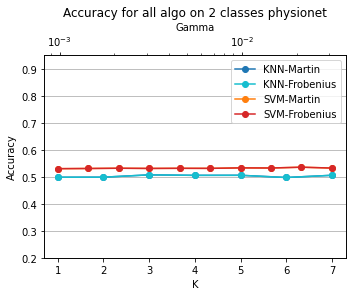

In [5]:
colors_KNN = ['tab:blue', 'tab:cyan']
colors_SVM = ['tab:orange', 'tab:red']
yrange =(0.2, 0.95)
size=(5,4)

plt.figure(figsize=size)
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.grid(axis='y')
plt.ylim(yrange)
algo = 'KNN'
for j, dist_name in enumerate(['Martin', 'Frobenius']):
    plt.plot(ks, algo_accuracies[f'{algo}-{dist_name}'],
            color=colors_KNN[j], marker='o', label=f'{algo}-{dist_name}')


ax1 = plt.gca()
handles, labels = ax1.get_legend_handles_labels()
ax2 = ax1.twiny()
ax2.set_xlabel('Gamma')
ax2.tick_params(axis='x')
ax2.set_xscale('log')

algo = 'SVM'
for j, dist_name in enumerate(['Martin', 'Frobenius']):
    ax2.plot(gammas, algo_accuracies[f'{algo}-{dist_name}'],
            color=colors_SVM[j], marker='o', label=f'{algo}-{dist_name}')
handles_, labels_ = ax2.get_legend_handles_labels()
plt.legend(handles+handles_, labels+labels_)
plt.tight_layout()

#plt.savefig('data_generated/physionet/2class/accuracy')
plt.title('Accuracy for all algo on 2 classes physionet')
plt.show()

## Misc

In [19]:
# Pick 10 random of each class
c0 = np.random.choice(np.arange(len(X_ma))[y==0], size=10, replace=False)
c1 = np.random.choice(np.arange(len(X_ma))[y==1], size=10, replace=False)
print('Indices class 0:', c0)
print('Indices class 1:', c1)
print()

diff = []
for i in c0:
    for j in c1:
        diff.append(full_gram_matrix[i,j])
diff = np.round(np.unique(diff), 2)
print(diff)
print()

same0 = []
for i in c0:
    for j in c0:
        same0.append(full_gram_matrix[i,j])
same0 = np.round(np.unique(same0), 2)
print(same0)
print()

same1 = []
for i in c1:
    for j in c1:
        same1.append(full_gram_matrix[i,j])
same1 = np.round(np.unique(same1), 2)
print(same1)

Indices class 0: [3627 3246  318  424 3307  443 1759 2505 2030 2458]
Indices class 1: [3672 4370 1697 2332 1993 2262  957 3505  516 3950]
[19.91 20.63 21.77 22.67 23.24 23.47 24.14 24.41 25.47 26.55 26.89 27.35
 27.39 27.63 28.59 28.77 28.84 29.42 29.48 29.65 30.07 30.18 30.41 30.57
 31.2  32.42 32.51 32.83 33.16 33.27 34.31 34.75 34.9  34.9  35.08 35.18
 35.24 35.3  35.69 36.09 36.37 36.55 36.72 36.79 36.85 37.05 37.07 37.31
 37.69 37.69 37.96 38.08 38.22 38.38 38.94 38.95 39.36 39.45 39.78 40.71
 41.36 41.88 42.42 42.69 42.75 42.97 43.32 46.69 46.89 46.95 47.54 47.86
 48.36 48.67 49.31 49.37 49.56 49.58 49.74 50.28 50.39 50.86 51.69 51.72
 52.02 52.06 53.22 53.83 54.16 54.28 55.66 55.84 58.24 59.72 59.88 60.79
 62.59 62.86 71.09 88.49]

[ 0.    0.    0.    0.    0.    0.    0.   22.4  26.72 27.81 28.01 28.08
 28.86 29.43 29.82 30.13 30.58 31.27 33.02 33.26 33.34 33.5  34.35 34.53
 36.17 36.49 36.74 36.93 37.2  37.61 37.98 38.2  38.58 39.2  39.44 39.63
 40.78 41.8  41.93 42.07 43.15 4